## Note: the cells below until Feature Selection is same as Multi_Ce_RandomForest.ipynb

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
import lightgbm as lgb
from bayes_opt import BayesianOptimization
import warnings
import xgboost as xgb
from skopt import BayesSearchCV
from scipy.stats import randint
from catboost import CatBoostRegressor, Pool
import optuna

# Import Data

In [10]:
df = pd.read_csv("combined_df.csv")
df = df[
    (df['Year'] >= 2020) &
    ((df['Headliner'].str.contains('"', na=False))) & 
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
# df = df.dropna()
# # Reset index after dropping rows
# df = df.reset_index(drop=True)
df

/var/folders/5p/g82q05js0bs2xkv11dw5ksy80000gn/T/ipykernel_1799/2258568049.py:1: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_df.csv")


,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
7,2024-09-11,"Greg ""G"" Williams",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Comedy,40.0,1240.00,220.0,18%,25.0,35.0,31.00,9,2
56,2024-09-05,"""K-Pop Club Night""","""K-Pop Club Night""","['k-pop', 'k-pop girl group']",9156939.0,82.0,"""K-Pop Club Night""",UCSSEYmHc2HGnFWwHhRXY5kA,P Su,NaN,...,Pop / Rock,361.0,9113.00,1600.0,22%,22.0,35.0,25.24,9,3
60,2024-09-05,"""RuPaul's Drag Race""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,1524.0,108716.75,3048.0,50%,25.0,99.5,71.34,9,3
80,2024-09-03,"""Avatar: The Last Airbender In Concert""","""Avatar: The Last Airbender In Concert""","['pixel', 'video game music']",1025270.0,73.0,"""Avatar: The Last Airbender In Concert""",UCugEMaKUpe62yldZ2DECTEQ,Robert Van Der Vliet,NaN,...,Pop / Rock,689.0,36846.00,1881.0,36%,20.0,125.0,53.48,9,1
93,2024-09-01,"""RuPaul's Drag Race""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,2108.0,162809.00,2704.0,77%,49.5,99.5,77.23,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109659,2020-01-02,"Cirque du Soleil - ""Axel""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,3280.0,200146.17,20000.0,16%,25.0,110.0,61.01,1,3
109663,2020-01-02,"Cirque du Soleil - ""Ovo""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Theatrical,1142.0,63001.50,3908.0,29%,39.0,125.0,55.16,1,3
109672,2020-01-01,"""Voices On The Hudson"", Joseph Arthur",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Americana, Multi-Genre",89.0,2810.00,100.0,89%,30.0,35.0,31.40,1,2
109682,2020-01-01,"""Hangover Ball""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Pop / Rock,1119.0,26255.00,1700.0,65%,22.0,42.0,23.46,1,2


In [11]:
# Calculate # and % of missing values in each column
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})

# sort missing values
missing_df = missing_df.sort_values(by='Missing Values', ascending=False)
missing_df

,Missing Values,Percentage
yt Description,8938,99.068943
yt View Count,8870,98.315229
yt Video Count,8870,98.315229
yt name,8870,98.315229
yt Channel ID,8870,98.315229
yt Title,8870,98.315229
yt Subscriber Count,8870,98.315229
yt Published At,8870,98.315229
35 to 44 years population,8866,98.270893
45 to 54 years population,8866,98.270893


In [12]:
# just keep columns with < 80% missing values
columns_to_keep = []
for col in df.columns:
    if missing_percent[col] < 80:
        columns_to_keep.append(col)

df_filtered = df[columns_to_keep]
df_filtered.head()

,Event Date,Headliner,Year,headliner_monthly_listeners,Support_Total_Monthly_Listeners,monthly_listeners,Number of Shows,Support,Venue,City,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
7,2024-09-11,"Greg ""G"" Williams",2024.0,0.0,0.0,NaN,1,NaN,City Winery Pittsburgh,Pittsburgh,...,Comedy,40.0,1240.00,220.0,18%,25.0,35.0,31.00,9,2
56,2024-09-05,"""K-Pop Club Night""",2024.0,0.0,0.0,NaN,1,NaN,Big Night Live,Boston,...,Pop / Rock,361.0,9113.00,1600.0,22%,22.0,35.0,25.24,9,3
60,2024-09-05,"""RuPaul's Drag Race""",2024.0,0.0,0.0,NaN,1,NaN,Altria Theater,Richmond,...,Theatrical,1524.0,108716.75,3048.0,50%,25.0,99.5,71.34,9,3
80,2024-09-03,"""Avatar: The Last Airbender In Concert""",2024.0,0.0,0.0,NaN,1,NaN,Washington Pavilion of Arts and Science - Mary...,Sioux Falls,...,Pop / Rock,689.0,36846.00,1881.0,36%,20.0,125.0,53.48,9,1
93,2024-09-01,"""RuPaul's Drag Race""",2024.0,0.0,0.0,NaN,1,NaN,DPAC,Durham,...,Theatrical,2108.0,162809.00,2704.0,77%,49.5,99.5,77.23,9,6


In [13]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 7 to 109685
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Event Date                       9022 non-null   object 
 1   Headliner                        9022 non-null   object 
 2   Year                             9022 non-null   float64
 3   headliner_monthly_listeners      9022 non-null   float64
 4   Support_Total_Monthly_Listeners  9022 non-null   float64
 5   monthly_listeners                1888 non-null   float64
 6   Number of Shows                  9022 non-null   int64  
 7   Support                          2029 non-null   object 
 8   Venue                            9022 non-null   object 
 9   City                             9022 non-null   object 
 10  State                            9022 non-null   object 
 11  Country                          9022 non-null   object 
 12  Market                 

In [14]:
# let consider monthly_listeners's effect, which has 79% missing value
print(df_filtered.groupby(df['monthly_listeners'].isnull())['Avg. Gross USD'].mean())

monthly_listeners
False    419099.173554
True      84256.754404
Name: Avg. Gross USD, dtype: float64


In [15]:
# corr for numerical feature
correlation_matrix = df_filtered.select_dtypes(include=['number']).corr()
print(correlation_matrix['Avg. Gross USD'].sort_values(ascending=False))

Avg. Gross USD                     1.000000
Avg. Tickets Sold                  0.872640
Avg. Event Capacity                0.786855
Ticket Price Max USD               0.568861
Support_Total_Monthly_Listeners    0.488328
monthly_listeners                  0.475429
Ticket Price Avg. USD              0.447727
Ticket Price Min USD               0.404142
Month                              0.041584
day_of_week                        0.025197
Number of Shows                    0.007792
headliner_monthly_listeners       -0.000263
Year                              -0.034602
Name: Avg. Gross USD, dtype: float64


In [16]:
# monthly_listeners takes a quite big role, 
# so we can fill na with median (with same artist) first
df_filtered = df_filtered.copy()
df_filtered.loc[:, 'monthly_listeners'] = df_filtered.groupby('Headliner')['monthly_listeners'].transform(lambda x: x.fillna(x.median()))

# then fill the remaining NaNs with the global median
df_filtered.loc[:, 'monthly_listeners'] = df_filtered['monthly_listeners'].fillna(df_filtered['monthly_listeners'].median())

# check monthly_listener missing value again
print("Missing values in monthly_listeners after final fill:", df_filtered['monthly_listeners'].isnull().sum())

Missing values in monthly_listeners after final fill: 0


In [17]:
# fill other features missing value
df_filtered = df_filtered.copy()

df_filtered.loc[:, 'Support'] = df_filtered['Support'].fillna(df_filtered['Support'].mode()[0])
df_filtered.loc[:, 'Market'] = df_filtered['Market'].fillna(df_filtered['Market'].mode()[0])
df_filtered.loc[:, 'Promoter'] = df_filtered['Promoter'].fillna(df_filtered['Promoter'].mode()[0])
df_filtered.loc[:, 'Genre'] = df_filtered['Genre'].fillna(df_filtered['Genre'].mode()[0])

In [18]:
print(df_filtered.dtypes)

Event Date                          object
Headliner                           object
Year                               float64
headliner_monthly_listeners        float64
Support_Total_Monthly_Listeners    float64
monthly_listeners                  float64
Number of Shows                      int64
Support                             object
Venue                               object
City                                object
State                               object
Country                             object
Market                              object
Company Type                        object
Currency                            object
Promoter                            object
Genre                               object
Avg. Tickets Sold                  float64
Avg. Gross USD                     float64
Avg. Event Capacity                float64
Avg. Capacity Sold                  object
Ticket Price Min USD               float64
Ticket Price Max USD               float64
Ticket Pric

In [19]:
# Ensure the Event Date is datetime type
df_filtered['Event Date'] = pd.to_datetime(df_filtered['Event Date'], errors='coerce')

df_filtered['Event Year'] = df_filtered['Event Date'].dt.year
df_filtered['Event Month'] = df_filtered['Event Date'].dt.month
df_filtered['Event Day'] = df_filtered['Event Date'].dt.day
df_filtered['Day of Week'] = df_filtered['Event Date'].dt.dayofweek  # 0=Monday, 6=Sunday

df_filtered.drop(columns=['Event Date'], inplace=True)

In [20]:
# check other feature's missing value
print(df_filtered.isnull().sum())

Headliner                          0
Year                               0
headliner_monthly_listeners        0
Support_Total_Monthly_Listeners    0
monthly_listeners                  0
Number of Shows                    0
Support                            0
Venue                              0
City                               0
State                              0
Country                            0
Market                             0
Company Type                       0
Currency                           0
Promoter                           0
Genre                              0
Avg. Tickets Sold                  0
Avg. Gross USD                     0
Avg. Event Capacity                0
Avg. Capacity Sold                 0
Ticket Price Min USD               0
Ticket Price Max USD               0
Ticket Price Avg. USD              0
Month                              0
day_of_week                        0
Event Year                         0
Event Month                        0
E

In [21]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 7 to 109685
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Headliner                        9022 non-null   object 
 1   Year                             9022 non-null   float64
 2   headliner_monthly_listeners      9022 non-null   float64
 3   Support_Total_Monthly_Listeners  9022 non-null   float64
 4   monthly_listeners                9022 non-null   float64
 5   Number of Shows                  9022 non-null   int64  
 6   Support                          9022 non-null   object 
 7   Venue                            9022 non-null   object 
 8   City                             9022 non-null   object 
 9   State                            9022 non-null   object 
 10  Country                          9022 non-null   object 
 11  Market                           9022 non-null   object 
 12  Company Type           

# Feature Selection

In [23]:
# Goal: encoding all categroical features and rank all features' score by using feature importance
# use different ways to encode different categorical features.

In [24]:
df_filtered = df_filtered.copy()
# Frequency Encoding
high_cardinality_cols = ['Headliner', 'Support', 'Venue', 'City', 'State', 'Country', 'Market', 'Promoter']

for col in high_cardinality_cols:
    freq_encoding = df_filtered[col].value_counts().to_dict()
    df_filtered.loc[:, col] = df_filtered[col].map(freq_encoding)


# Ordinal Encoder
ordinal_cols = ['Company Type', 'Currency', 'Genre']

ordinal_encoder = OrdinalEncoder()
df_filtered.loc[:, ordinal_cols] = ordinal_encoder.fit_transform(df_filtered[ordinal_cols])

# One-Hot Encoding
df_filtered = pd.get_dummies(df_filtered, columns=['Avg. Capacity Sold'], drop_first=True)

# check type
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9022 entries, 7 to 109685
Columns: 134 entries, Headliner to Avg. Capacity Sold_99%
dtypes: bool(106), float64(10), int32(4), int64(3), object(11)
memory usage: 2.8+ MB


In [25]:
# check all object type feature in dataframe
categorical_columns = df_filtered.select_dtypes(include=['object']).columns
print("those columns are still categorical feature, need tansform", categorical_columns)

# use category convert
for col in categorical_columns:
    df_filtered[col] = df_filtered[col].astype('category').cat.codes

print(df_filtered.dtypes)

those columns are still categorical feature, need tansform Index(['Headliner', 'Support', 'Venue', 'City', 'State', 'Country', 'Market',
       'Company Type', 'Currency', 'Promoter', 'Genre'],
      dtype='object')
Headliner                             int8
Year                               float64
headliner_monthly_listeners        float64
Support_Total_Monthly_Listeners    float64
monthly_listeners                  float64
                                    ...   
Avg. Capacity Sold_95%                bool
Avg. Capacity Sold_96%                bool
Avg. Capacity Sold_97%                bool
Avg. Capacity Sold_98%                bool
Avg. Capacity Sold_99%                bool
Length: 134, dtype: object


In [26]:
df_filtered

,Headliner,Year,headliner_monthly_listeners,Support_Total_Monthly_Listeners,monthly_listeners,Number of Shows,Support,Venue,City,State,...,Avg. Capacity Sold_90%,Avg. Capacity Sold_91%,Avg. Capacity Sold_92%,Avg. Capacity Sold_93%,Avg. Capacity Sold_94%,Avg. Capacity Sold_95%,Avg. Capacity Sold_96%,Avg. Capacity Sold_97%,Avg. Capacity Sold_98%,Avg. Capacity Sold_99%
7,0,2024.0,0.0,0.0,1657487.0,1,21,26,46,37,...,False,False,False,False,False,False,False,False,False,False
56,9,2024.0,0.0,0.0,1657487.0,1,21,65,85,41,...,False,False,False,False,False,False,False,False,False,False
60,39,2024.0,0.0,0.0,1657487.0,1,21,50,70,33,...,False,False,False,False,False,False,False,False,False,False
80,14,2024.0,0.0,0.0,1657487.0,1,21,43,48,17,...,False,False,False,False,False,False,False,False,False,False
93,39,2024.0,0.0,0.0,1657487.0,1,21,62,71,43,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109659,2,2020.0,0.0,0.0,1657487.0,6,21,10,77,35,...,False,False,False,False,False,False,False,False,False,False
109663,8,2020.0,0.0,0.0,1657487.0,6,21,3,7,42,...,False,False,False,False,False,False,False,False,False,False
109672,0,2020.0,0.0,0.0,1657487.0,2,21,27,86,46,...,False,False,False,False,False,False,False,False,False,False
109682,0,2020.0,0.0,1120797.0,1120797.0,1,0,0,30,15,...,False,False,False,False,False,False,False,False,False,False


# Train the Model

## Default LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 7217, number of used features: 109
[LightGBM] [Info] Start training from score 151290.305725

=== Top 10 Features ===
['Avg. Tickets Sold', 'Ticket Price Avg. USD', 'Ticket Price Min USD', 'Avg. Event Capacity', 'Ticket Price Max USD', 'Support_Total_Monthly_Listeners', 'monthly_listeners', 'Event Day', 'Market', 'Genre']


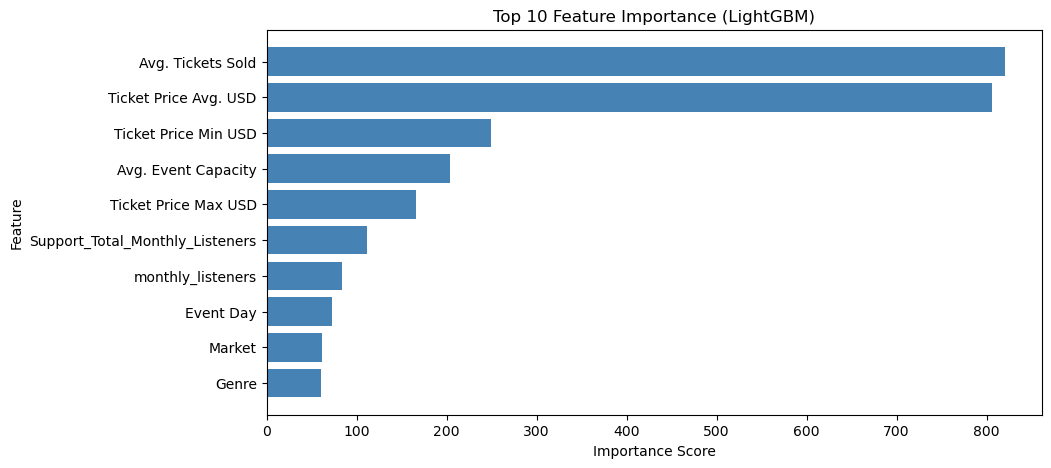

In [29]:
target = 'Avg. Gross USD'
features = [col for col in df_filtered.columns if col != target]

X = df_filtered[features]
y = df_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train LightGBM and get feature importance
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# choose top 10
top_10_features = feature_importance['Feature'].head(10).tolist()
print("\n=== Top 10 Features ===")
print(top_10_features)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10), color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance (LightGBM)')
plt.show()

In [30]:
# reset train & test set (only use top 10)
X_train_top = X_train[top_10_features]
X_test_top = X_test[top_10_features]
X_train_top.columns = X_train_top.columns.str.replace(" ", "_")
X_test_top.columns = X_test_top.columns.str.replace(" ", "_")

# train default LightGBM
default_lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)

# cv
cv_mae = cross_val_score(default_lgb_model, X_train_top, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(default_lgb_model, X_train_top, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(default_lgb_model, X_train_top, y_train, cv=5, scoring='r2')

print("\n=== Default LightGBM Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {-np.mean(cv_mae):.5f}")
print(f" Average RMSE: {-np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

# train
default_lgb_model.fit(X_train_top, y_train)

# predict
y_test_pred = default_lgb_model.predict(X_test_top)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n=== Default LightGBM Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Default LightGBM Cross-Validation Results (Training Set) ===
 Average MAE: 16151.69223
 Average RMSE: 149178.96456
 Average R²: 0.86545

=== Default LightGBM Test Set Results ===
 MAE: 13888.88466
 RMSE: 140143.33443
 R²: 0.91915


## XGBoost

In [32]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# CV
cv_mae = cross_val_score(xgb_model, X_train_top, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(xgb_model, X_train_top, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(xgb_model, X_train_top, y_train, cv=5, scoring='r2')

print("\n=== XGBoost Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {-np.mean(cv_mae):.5f}")
print(f" Average RMSE: {-np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

xgb_model.fit(X_train_top, y_train)

y_test_pred = xgb_model.predict(X_test_top)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n=== XGBoost Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== XGBoost Cross-Validation Results (Training Set) ===
 Average MAE: 11146.85495
 Average RMSE: 99581.75019
 Average R²: 0.93806

=== XGBoost Test Set Results ===
 MAE: 16488.97342
 RMSE: 193693.97396
 R²: 0.84555


## Random Forest

In [34]:
# random search
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.5, 0.75]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20, 
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

random_search.fit(X_train_top, y_train)

print("=== Best Parameters from Randomized Search ===")
print(random_search.best_params_)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


=== Best Parameters from Randomized Search ===
{'max_depth': 13, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 747}


In [35]:
# Grid Search（fine turn base on Random Search result）
param_grid = {
    'max_depth': [11, 13, 15], # 15
    'max_features': [0.7, 0.75, 0.8], # 0.8
    'min_samples_leaf': [1, 2], # 1
    'min_samples_split': [4, 5, 6], # 4
    'n_estimators': [700, 747, 800] # 700
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_top, y_train)

print("=== Best Parameters from Grid Search ===")
print(grid_search.best_params_)

=== Best Parameters from Grid Search ===
{'max_depth': 15, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 700}


In [36]:
# retrain best Random Forest
best_rf = RandomForestRegressor(
    max_depth=15,
    max_features=0.8,
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=700,
    random_state=42
)

# Cross Validation
cv_mae = cross_val_score(best_rf, X_train_top, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(best_rf, X_train_top, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(best_rf, X_train_top, y_train, cv=5, scoring='r2')

best_rf.fit(X_train_top, y_train)

y_test_pred_rf = best_rf.predict(X_test_top)

test_mae = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_r2 = r2_score(y_test, y_test_pred_rf)

print("\n=== Optimized Random Forest Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {-np.mean(cv_mae):.5f}")
print(f" Average RMSE: {-np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

print("\n=== Optimized Random Forest Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Optimized Random Forest Cross-Validation Results (Training Set) ===
 Average MAE: 9637.90328
 Average RMSE: 114318.83506
 Average R²: 0.91985

=== Optimized Random Forest Test Set Results ===
 MAE: 7830.33863
 RMSE: 94664.02557
 R²: 0.96311


## CatBoost

In [38]:
categorical_features = ['Genre', 'Market']

X = df_filtered[top_10_features]
y = df_filtered['Avg. Gross USD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build Pool
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Initialization
cat_model = CatBoostRegressor(
    iterations=14000,
    learning_rate=0.05,
    depth=6,
    eval_metric='MAE',
    random_seed=42,
    verbose=100
)

cat_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

y_pred = cat_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"CatBoost MAE: {mae:.5f}")
print(f"CatBoost RMSE: {rmse:.5f}")
print(f"CatBoost R²: {r2:.5f}")

0:	learn: 150506.9494640	test: 162177.7351339	best: 162177.7351339 (0)	total: 60.6ms	remaining: 14m 7s
100:	learn: 26315.1980986	test: 31800.0233520	best: 31800.0233520 (100)	total: 253ms	remaining: 34.8s
200:	learn: 16333.9463286	test: 22428.6787068	best: 22428.6787068 (200)	total: 449ms	remaining: 30.8s
300:	learn: 10223.3152321	test: 17115.3945263	best: 17115.3945263 (300)	total: 647ms	remaining: 29.4s
400:	learn: 7905.2235303	test: 15223.7577990	best: 15223.7577990 (400)	total: 840ms	remaining: 28.5s
500:	learn: 6396.8877368	test: 14122.1292579	best: 14122.1292579 (500)	total: 1.03s	remaining: 27.8s
600:	learn: 5437.3090570	test: 13414.5266087	best: 13414.5266087 (600)	total: 1.23s	remaining: 27.3s
700:	learn: 4730.4558808	test: 12869.3026599	best: 12869.3026599 (700)	total: 1.45s	remaining: 27.5s
800:	learn: 4194.4347747	test: 12507.0716584	best: 12507.0716584 (800)	total: 1.65s	remaining: 27.2s
900:	learn: 3742.0596395	test: 12205.8486029	best: 12205.3540358 (899)	total: 1.84s	re

In [42]:
categorical_features = ['Genre', 'Market']
X = df_filtered[top_10_features]
y = df_filtered['Avg. Gross USD']

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_list = []
rmse_list = []
r2_list = []

catboost_params = {
    'iterations': 14000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'MAE',
    'loss_function': 'RMSE',
    'early_stopping_rounds': 100,
    'verbose': 500,
    'random_seed': 42
}

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n===== Fold {fold} =====")
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    train_pool = Pool(X_train_fold, y_train_fold, cat_features=categorical_features)
    val_pool = Pool(X_val_fold, y_val_fold, cat_features=categorical_features)

    model = CatBoostRegressor(**catboost_params)
    model.fit(train_pool, eval_set=val_pool)

    y_pred = model.predict(X_val_fold)

    mae = mean_absolute_error(y_val_fold, y_pred)
    rmse = mean_squared_error(y_val_fold, y_pred, squared=False)
    r2 = r2_score(y_val_fold, y_pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"MAE: {mae:.5f}, RMSE: {rmse:.5f}, R²: {r2:.5f}")

print("\n=== CatBoost 5-Fold CV Final Results ===")
print(f"Avg MAE : {np.mean(mae_list):.5f}")
print(f"Avg RMSE: {np.mean(rmse_list):.5f}")
print(f"Avg R²  : {np.mean(r2_list):.5f}")


===== Fold 1 =====
0:	learn: 150506.9494640	test: 162177.7351339	best: 162177.7351339 (0)	total: 5.14ms	remaining: 1m 11s
500:	learn: 6463.7838979	test: 14172.3245857	best: 14170.9571743 (499)	total: 1.03s	remaining: 27.9s
1000:	learn: 3470.1745367	test: 12032.2324858	best: 12032.2324858 (1000)	total: 2s	remaining: 25.9s
1500:	learn: 2382.7852995	test: 11350.0433449	best: 11350.0433449 (1500)	total: 2.97s	remaining: 24.7s
2000:	learn: 1835.7945600	test: 11044.8345961	best: 11044.2820041 (1999)	total: 4s	remaining: 24s
2500:	learn: 1498.1153801	test: 10867.7630552	best: 10867.7630552 (2500)	total: 5s	remaining: 23s
3000:	learn: 1264.2787940	test: 10755.6320313	best: 10755.6320313 (3000)	total: 5.98s	remaining: 21.9s
3500:	learn: 1089.9413421	test: 10676.9867534	best: 10676.9867534 (3500)	total: 6.94s	remaining: 20.8s
4000:	learn: 962.2591103	test: 10619.5763711	best: 10619.5763711 (4000)	total: 7.89s	remaining: 19.7s
4500:	learn: 864.2169896	test: 10578.7814232	best: 10578.7814232 (450

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


500:	learn: 6113.9953161	test: 13965.0244430	best: 13965.0244430 (500)	total: 977ms	remaining: 26.3s
1000:	learn: 3398.4894035	test: 12009.0068698	best: 12009.0068698 (1000)	total: 1.92s	remaining: 24.9s
1500:	learn: 2408.9181195	test: 11415.1974125	best: 11415.1466583 (1499)	total: 2.87s	remaining: 23.9s
2000:	learn: 1882.1372595	test: 11147.1149152	best: 11147.1149152 (2000)	total: 3.84s	remaining: 23s
2500:	learn: 1552.4986425	test: 10998.8980105	best: 10998.8980105 (2500)	total: 4.8s	remaining: 22.1s
3000:	learn: 1320.6398374	test: 10895.4533425	best: 10895.4533425 (3000)	total: 5.75s	remaining: 21.1s
3500:	learn: 1140.5141099	test: 10808.3819348	best: 10808.3819348 (3500)	total: 6.73s	remaining: 20.2s
4000:	learn: 1001.1158245	test: 10753.8452930	best: 10753.8452930 (4000)	total: 7.7s	remaining: 19.2s
4500:	learn: 891.4698461	test: 10711.3944751	best: 10711.3944751 (4500)	total: 8.67s	remaining: 18.3s
5000:	learn: 801.0726300	test: 10679.5805053	best: 10679.5805053 (5000)	total: 9

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


500:	learn: 5983.5216310	test: 8208.1091963	best: 8208.1091963 (500)	total: 944ms	remaining: 25.4s
1000:	learn: 3226.7041777	test: 6372.6232731	best: 6372.6232731 (1000)	total: 1.9s	remaining: 24.6s
1500:	learn: 2284.9278740	test: 5847.3696262	best: 5847.3696262 (1500)	total: 2.84s	remaining: 23.7s
2000:	learn: 1801.4192755	test: 5598.4530471	best: 5598.4530471 (2000)	total: 3.79s	remaining: 22.7s
2500:	learn: 1487.1741615	test: 5443.9202886	best: 5443.9202886 (2500)	total: 4.75s	remaining: 21.8s
3000:	learn: 1261.6523603	test: 5340.4490631	best: 5340.1269981 (2996)	total: 5.69s	remaining: 20.9s
3500:	learn: 1101.1980621	test: 5272.7074483	best: 5272.6948205 (3498)	total: 6.64s	remaining: 19.9s
4000:	learn: 976.1337430	test: 5222.5354509	best: 5222.5354509 (4000)	total: 7.59s	remaining: 19s
4500:	learn: 867.3088957	test: 5171.3986882	best: 5171.3986882 (4500)	total: 8.54s	remaining: 18s
5000:	learn: 780.7121770	test: 5139.4609154	best: 5139.4609154 (5000)	total: 9.51s	remaining: 17.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


500:	learn: 5504.6069706	test: 13048.3817732	best: 13048.3817732 (500)	total: 985ms	remaining: 26.5s
1000:	learn: 3172.9111116	test: 11660.7969977	best: 11660.6434771 (996)	total: 1.98s	remaining: 25.7s
1500:	learn: 2302.6220009	test: 11123.0350121	best: 11122.6041077 (1498)	total: 2.97s	remaining: 24.7s
2000:	learn: 1786.1969999	test: 10786.4714787	best: 10786.4714787 (2000)	total: 3.97s	remaining: 23.8s
2500:	learn: 1470.2698437	test: 10627.2112916	best: 10627.2112916 (2500)	total: 4.93s	remaining: 22.7s
3000:	learn: 1238.9574130	test: 10511.8406388	best: 10511.8406388 (3000)	total: 5.91s	remaining: 21.7s
3500:	learn: 1072.0221949	test: 10443.3570616	best: 10443.2168899 (3497)	total: 6.87s	remaining: 20.6s
4000:	learn: 943.9313552	test: 10386.9736493	best: 10386.9736493 (4000)	total: 7.83s	remaining: 19.6s
4500:	learn: 839.5995900	test: 10339.7168967	best: 10339.7168967 (4500)	total: 8.77s	remaining: 18.5s
5000:	learn: 754.8415769	test: 10308.3044626	best: 10308.2306938 (4998)	total:

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


500:	learn: 6699.4887846	test: 10786.2931092	best: 10786.2931092 (500)	total: 976ms	remaining: 26.3s
1000:	learn: 3451.6561299	test: 8350.1184018	best: 8350.1184018 (1000)	total: 1.92s	remaining: 24.9s
1500:	learn: 2459.1155308	test: 7746.1172524	best: 7746.1172524 (1500)	total: 2.85s	remaining: 23.7s
2000:	learn: 1911.4221840	test: 7454.7380550	best: 7454.7380550 (2000)	total: 3.82s	remaining: 22.9s
2500:	learn: 1564.0331017	test: 7275.1846567	best: 7274.9852472 (2495)	total: 4.77s	remaining: 21.9s
3000:	learn: 1331.3140733	test: 7166.2889395	best: 7166.1514734 (2999)	total: 5.73s	remaining: 21s
3500:	learn: 1153.1172668	test: 7090.0520009	best: 7089.9893058 (3499)	total: 6.69s	remaining: 20.1s
4000:	learn: 1014.8899391	test: 7025.7590480	best: 7025.7371653 (3993)	total: 7.65s	remaining: 19.1s
4500:	learn: 902.9064941	test: 6979.1629250	best: 6979.0113779 (4497)	total: 8.6s	remaining: 18.2s
5000:	learn: 807.1834992	test: 6940.1551093	best: 6940.1551093 (5000)	total: 9.57s	remaining: 1

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Ensemble

### Averaging

In [55]:
cv_preds_lgb = cross_val_predict(default_lgb_model, X_train_top, y_train, cv=5)
cv_preds_xgb = cross_val_predict(xgb_model, X_train_top, y_train, cv=5)

# alpha = 0.5  # 50% LightGBM + 50% XGBoost
alpha = 0.7  # 70% LightGBM + 30% XGBoost


# ensemble
cv_preds_ensemble = alpha * cv_preds_lgb + (1 - alpha) * cv_preds_xgb

cv_mae = mean_absolute_error(y_train, cv_preds_ensemble)
cv_rmse = np.sqrt(mean_squared_error(y_train, cv_preds_ensemble))
cv_r2 = r2_score(y_train, cv_preds_ensemble)

print("\n=== Averaging Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {cv_mae:.5f}")
print(f" Average RMSE: {cv_rmse:.5f}")
print(f" Average R²: {cv_r2:.5f}")

y_pred_lgb = default_lgb_model.predict(X_test_top)
y_pred_xgb = xgb_model.predict(X_test_top)

y_pred_ensemble = alpha * y_pred_lgb + (1 - alpha) * y_pred_xgb

test_mae = mean_absolute_error(y_test, y_pred_ensemble)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
test_r2 = r2_score(y_test, y_pred_ensemble)

print("\n=== Averaging Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Averaging Ensemble Cross-Validation Results (Training Set) ===
 Average MAE: 13117.98609
 Average RMSE: 132773.05203
 Average R²: 0.89657

=== Averaging Ensemble Test Set Results ===
 MAE: 13394.23073
 RMSE: 150135.67388
 R²: 0.90720


### Stacking (2nd layer: linear regression)

In [57]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import numpy as np

# set k fold to 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_meta = np.zeros((X_train_top.shape[0], 2))
test_meta = np.zeros((X_test_top.shape[0], 2))
test_meta_kfold = np.zeros((5, X_test_top.shape[0], 2))

# First layer model：LightGBM & XGBoost
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_top)):
    X_tr, X_val = X_train_top.iloc[train_idx], X_train_top.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # train LightGBM
    lgb_model = lgb.LGBMRegressor(random_state=42)
    lgb_model.fit(X_tr, y_tr)
    train_meta[val_idx, 0] = lgb_model.predict(X_val)
    test_meta_kfold[i, :, 0] = lgb_model.predict(X_test_top)

    # train XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_tr, y_tr)
    train_meta[val_idx, 1] = xgb_model.predict(X_val)
    test_meta_kfold[i, :, 1] = xgb_model.predict(X_test_top)

# Take the average of 5 times on the test set
test_meta[:, 0] = test_meta_kfold[:, :, 0].mean(axis=0)
test_meta[:, 1] = test_meta_kfold[:, :, 1].mean(axis=0)

# The second layer model: linear regression
meta_model = LinearRegression()
meta_model.fit(train_meta, y_train)

train_meta_pred = meta_model.predict(train_meta)
train_mae = mean_absolute_error(y_train, train_meta_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_meta_pred))
train_r2 = r2_score(y_train, train_meta_pred)

test_meta_pred = meta_model.predict(test_meta)
test_mae = mean_absolute_error(y_test, test_meta_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_meta_pred))
test_r2 = r2_score(y_test, test_meta_pred)

print("\n=== Stacking Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {train_mae:.5f}")
print(f" Average RMSE: {train_rmse:.5f}")
print(f" Average R²: {train_r2:.5f}")

print("\n=== Stacking Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Stacking Ensemble Cross-Validation Results (Training Set) ===
 Average MAE: 18386.49580
 Average RMSE: 122318.50912
 Average R²: 0.91221

=== Stacking Ensemble Test Set Results ===
 MAE: 20884.18677
 RMSE: 151677.83858
 R²: 0.90529


### Stacking (2nd layer: random forest)

In [59]:
meta_train_lgb = cross_val_predict(lgb_model, X_train_top, y_train, cv=5, method="predict")
meta_train_xgb = cross_val_predict(xgb_model, X_train_top, y_train, cv=5, method="predict")

meta_features = np.column_stack((meta_train_lgb, meta_train_xgb))

# Train the second layer model: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(meta_features, y_train)

# CV
cv_mae = -cross_val_score(rf_model, meta_features, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = -cross_val_score(rf_model, meta_features, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(rf_model, meta_features, y_train, cv=5, scoring='r2')

print("\n=== Stacking Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {np.mean(cv_mae):.5f}")
print(f" Average RMSE: {np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

meta_test_lgb = lgb_model.predict(X_test_top)
meta_test_xgb = xgb_model.predict(X_test_top)
meta_test_features = np.column_stack((meta_test_lgb, meta_test_xgb))

y_pred_rf = rf_model.predict(meta_test_features)

test_mae = mean_absolute_error(y_test, y_pred_rf)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
test_r2 = r2_score(y_test, y_pred_rf)

print("\n=== Stacking Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Stacking Ensemble Cross-Validation Results (Training Set) ===
 Average MAE: 13031.75177
 Average RMSE: 136078.99077
 Average R²: 0.88452

=== Stacking Ensemble Test Set Results ===
 MAE: 11543.10732
 RMSE: 116631.53814
 R²: 0.94400


In [60]:
# Turn hyper-parameter: BayesSearchCV on rf(meta learner model)
param_space = {
    'n_estimators': (50, 500), 
    'max_depth': (5, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'max_features': ('sqrt', 'log2')
}

rf_model = RandomForestRegressor(random_state=42)

# Search for parameters using Bayesian optimization
opt_rf = BayesSearchCV(
    rf_model,
    param_space,
    n_iter=30,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

opt_rf.fit(meta_features, y_train)

print("\n=== Best Parameters for RandomForest Stacking ===")
print(opt_rf.best_params_)

best_rf = RandomForestRegressor(**opt_rf.best_params_, random_state=42)
best_rf.fit(meta_features, y_train)

# ========== (Training Set) ==========
cv_mae = cross_val_score(best_rf, meta_features, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(best_rf, meta_features, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(best_rf, meta_features, y_train, cv=5, scoring='r2')

print("\n=== Optimized Stacking Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {-np.mean(cv_mae):.5f}")
print(f" Average RMSE: {-np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

# ========== (Test Set) ==========
meta_test_lgb = lgb_model.predict(X_test_top)
meta_test_xgb = xgb_model.predict(X_test_top)
meta_test_features = np.column_stack((meta_test_lgb, meta_test_xgb))

y_pred_rf = best_rf.predict(meta_test_features)

test_mae = mean_absolute_error(y_test, y_pred_rf)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
test_r2 = r2_score(y_test, y_pred_rf)

print("\n=== Optimized Stacking Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")


=== Best Parameters for RandomForest Stacking ===
OrderedDict({'max_depth': 48, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 500})

=== Optimized Stacking Ensemble Cross-Validation Results (Training Set) ===
 Average MAE: 12495.86911
 Average RMSE: 127574.57335
 Average R²: 0.89714

=== Optimized Stacking Ensemble Test Set Results ===
 MAE: 11901.86991
 RMSE: 111038.38417
 R²: 0.94924


In [67]:
X = df_filtered[top_10_features]
X.columns = X.columns.str.replace(" ", "_")

# categorical_features = ['Genre', 'Market']

# lgb_model, xgb_model, cat_model
meta_train_lgb = cross_val_predict(lgb_model, X, y_train, cv=5, method='predict')
meta_train_xgb = cross_val_predict(xgb_model, X, y_train, cv=5, method='predict')
meta_train_cat = cross_val_predict(cat_model, X, y_train, cv=5, method='predict')

meta_features = np.column_stack((meta_train_lgb, meta_train_xgb, meta_train_cat))

# ========== Meta Learner：RandomForestRegressor（best parameters after BayesSearchCV） ==========
best_rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=48,
    min_samples_split=6,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42
)

# Cross-validation on training set
cv_mae = cross_val_score(best_rf, meta_features, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_rmse = cross_val_score(best_rf, meta_features, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_r2 = cross_val_score(best_rf, meta_features, y_train, cv=5, scoring='r2')

print("\n=== Optimized Stacking Ensemble Cross-Validation Results (Training Set) ===")
print(f" Average MAE: {-np.mean(cv_mae):.5f}")
print(f" Average RMSE: {-np.mean(cv_rmse):.5f}")
print(f" Average R²: {np.mean(cv_r2):.5f}")

# Fit the meta model
best_rf.fit(meta_features, y_train)

# ========== Test Set ==========
meta_test_lgb = lgb_model.predict(X)
meta_test_xgb = xgb_model.predict(X)
meta_test_cat = cat_model.predict(X)

meta_test_features = np.column_stack((meta_test_lgb, meta_test_xgb, meta_test_cat))

# Final ensemble prediction
y_pred_rf = best_rf.predict(meta_test_features)

test_mae = mean_absolute_error(y_test, y_pred_rf)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
test_r2 = r2_score(y_test, y_pred_rf)

print("\n=== Optimized Stacking Ensemble Test Set Results ===")
print(f" MAE: {test_mae:.5f}")
print(f" RMSE: {test_rmse:.5f}")
print(f" R²: {test_r2:.5f}")

ValueError: Found input variables with inconsistent numbers of samples: [9022, 7217]